# Exchange rate DATA Time Series Analysis

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('exchange-rate-twi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              304 non-null    int64  
 1   Exchange Rate TWI  304 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.9 KB


In [4]:
data.head()

,Month,Exchange Rate TWI
0,1,100.0
1,2,99.6
2,3,99.4
3,4,99.1
4,5,99.2


In [5]:
data['Month'] = pd.date_range('01-01-1949','1974-05-01',freq='M')

In [6]:
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index('Month')


In [7]:
data.head()

,Exchange Rate TWI
Month,
1949-01-31,100.0
1949-02-28,99.6
1949-03-31,99.4
1949-04-30,99.1
1949-05-31,99.2


In [8]:
data.isnull().sum()

Exchange Rate TWI    0
dtype: int64

# Plot time series data

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

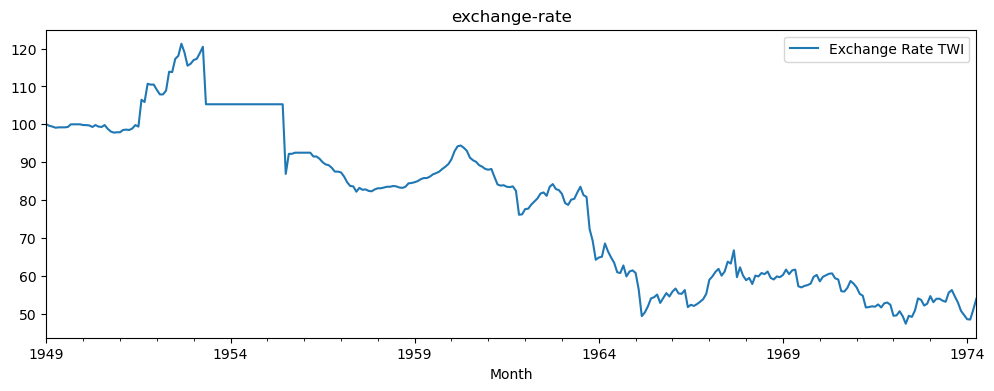

In [10]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('exchange-rate')
plt.show(block=False)

# Outlier detection

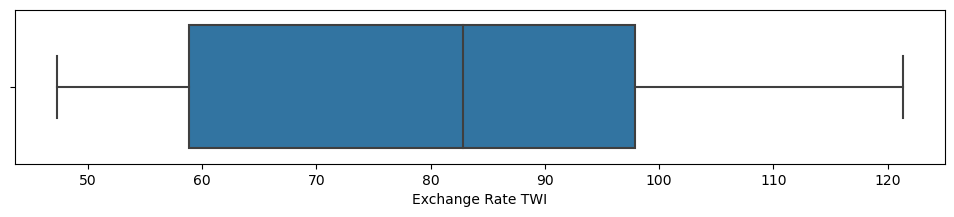

In [11]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Exchange Rate TWI'],whis=0.6)

# Histogram

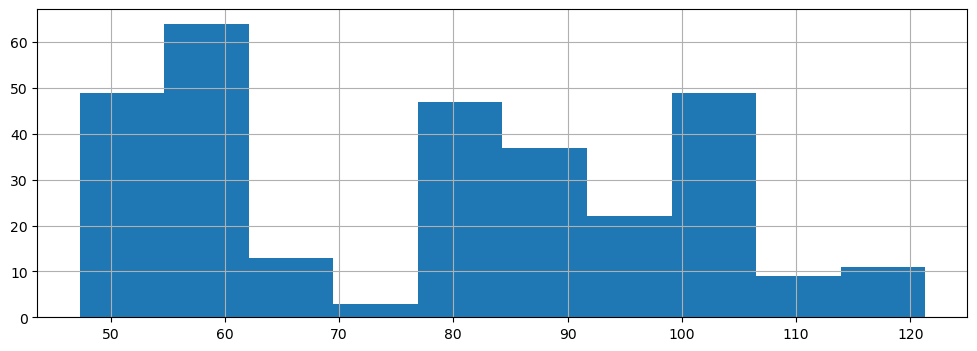

In [12]:
fig = data['Exchange Rate TWI'].hist(figsize = (12,4))

# Auto Regressive methods

## Augmented Dickey-Fuller (ADF) test

In [13]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Exchange Rate TWI'])

In [14]:
adf_test

(-0.8054678720541545,
 0.8175106426685048,
 0,
 303,
 {'1%': -3.4521175397304784,
  '5%': -2.8711265007266666,
  '10%': -2.571877823851692},
 1268.8696918056114)

In [15]:
print(adf_test[1])

0.8175106426685048


## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [16]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Exchange Rate TWI'])


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [17]:
kpss_test

(2.6144892040709946,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## Box Cox transformation to make variance constant

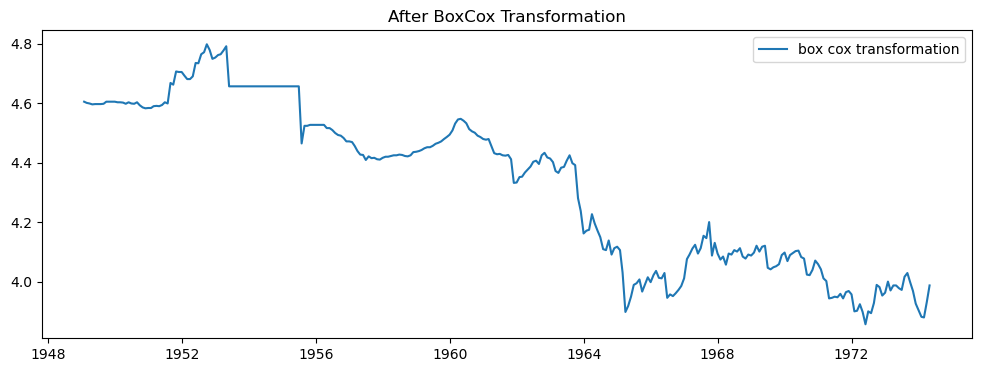

In [18]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Exchange Rate TWI'], lmbda= 0), index= data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label="box cox transformation")
plt.legend(loc='best')
plt.title('After BoxCox Transformation')
plt.show()

## Differencing to remove trend

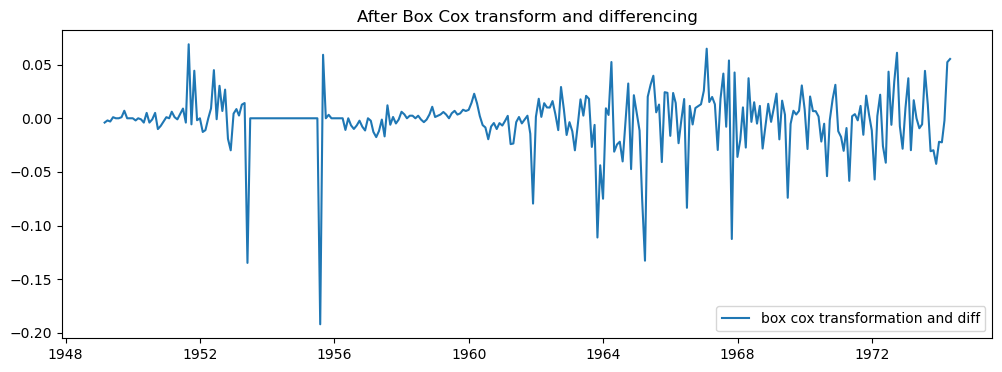

In [19]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index= data.index)
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label="box cox transformation and diff")
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()



In [20]:
data_boxcox_diff.dropna(inplace=True)

## Augmented Dickey-Fuller (ADF) test

In [21]:
adf_test = adfuller(data_boxcox_diff)
print("ADF stats : %f" % adf_test[0])
print('critical val: %f.2' % adf_test[4]['5%'])
print('p val:  %f' %adf_test[1])

ADF stats : -17.326930
critical val: -2.871158.2
p val:  0.000000


## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [22]:
kpss_test = kpss(data_boxcox_diff)
print("kpss stats : %f" % kpss_test[0])
print('critical val: %f.2' % kpss_test[3]['5%'])
print('p val:  %f' %kpss_test[1])

kpss stats : 0.066034
critical val: 0.463000.2
p val:  0.100000


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Autocorrelation function (ACF)

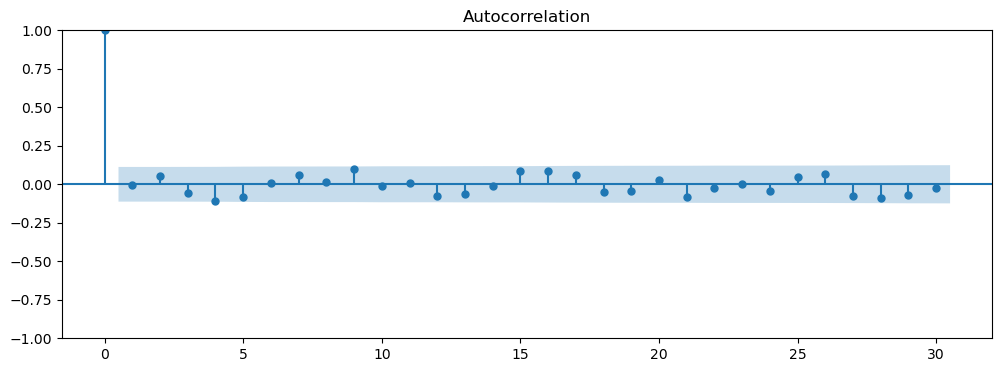

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))

plot_acf(data_boxcox_diff, ax= plt.gca(), lags=30)
plt.show()

## Partial autocorrelation function (PACF)

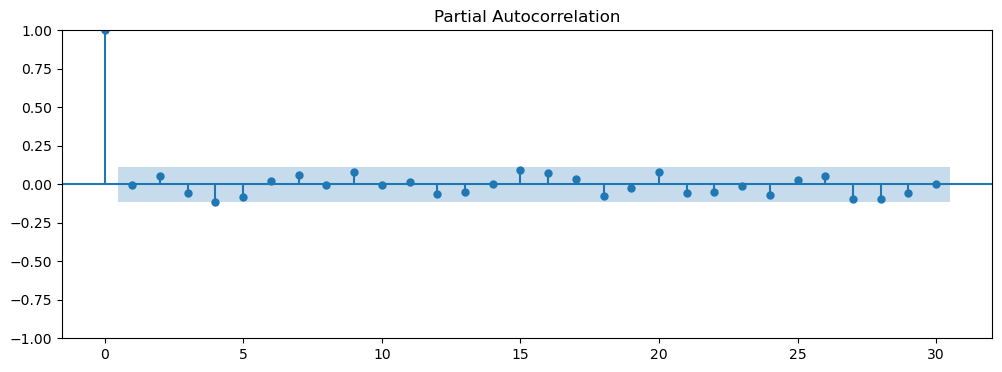

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))

plot_pacf(data_boxcox_diff, ax= plt.gca(), lags=30)
plt.show()

In [25]:
train_len = 212
train = data[0:train_len] 
test = data[train_len:]

In [26]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1] 
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [27]:
train_data_boxcox_diff

Month
1949-02-28   -0.004008
1949-03-31   -0.002010
1949-04-30   -0.003023
1949-05-31    0.001009
1949-06-30    0.000000
                ...   
1966-04-30   -0.001810
1966-05-31    0.017954
1966-06-30   -0.083459
1966-07-31    0.011539
1966-08-31   -0.005753
Name: Exchange Rate TWI, Length: 211, dtype: float64

# AUTO REGRESSION MODEL

In [28]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1,0,0))
model_fit = model.fit()
print(model_fit.params)

const    -0.003102
ar.L1     0.013071
sigma2    0.000734
dtype: float64


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


# RECOVER ORIGINAL TIME SERIES FORECAST

In [29]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

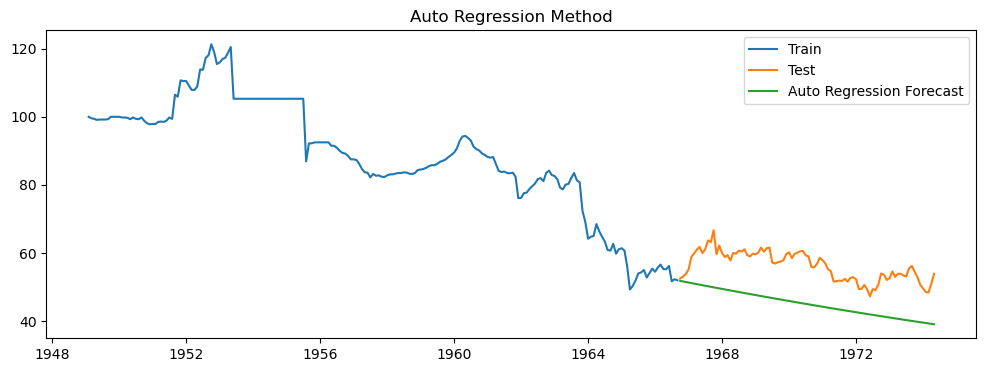

In [30]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label = 'Train')
plt.plot(test['Exchange Rate TWI'], label = 'Test')
plt.plot(y_hat_ar['ar_forecast'][test_data_boxcox_diff.index.min():], label = 'Auto Regression Forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

# Calculate RMSE and MAPE

In [31]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_ar['ar_forecast'][test.index.min():])/test['Exchange Rate TWI'])*100,2)

results = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,11.45,19.55


# MOVING AVERAGE

In [32]:
model = ARIMA(train_data_boxcox_diff, order=(0,0,1))
model_fit = model.fit()
print(model_fit.params)


const    -0.003104
ma.L1     0.011818
sigma2    0.000734
dtype: float64


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


# RECOVER ORIGINAL TIME SERIES FORECAST

In [33]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

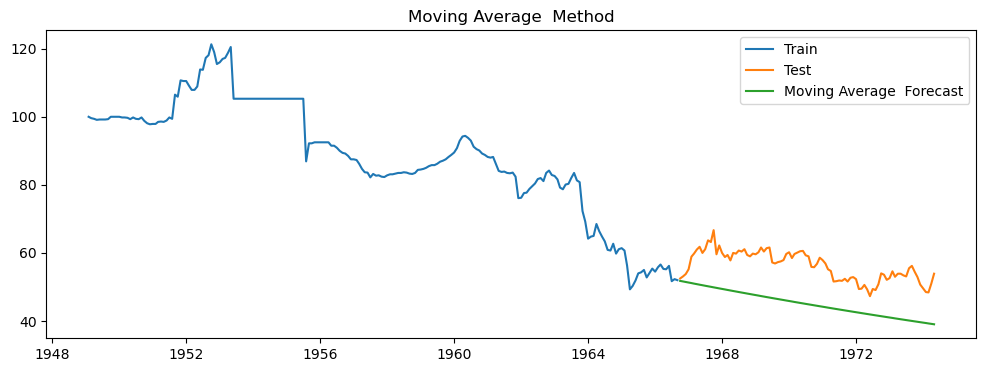

In [34]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label = 'Train')
plt.plot(test['Exchange Rate TWI'], label = 'Test')
plt.plot(y_hat_ma['ma_forecast'][test_data_boxcox_diff.index.min():], label = 'Moving Average  Forecast')
plt.legend(loc='best')
plt.title('Moving Average  Method')
plt.show()

# Calculate RMSE and MAPE

In [35]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_ma['ma_forecast'][test.index.min():])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,11.45,19.55
0,Moving Average (MA) method,11.48,19.60


# Auto regression moving average method (ARMA)

In [36]:
model = ARIMA(train_data_boxcox_diff, order=(1,0,1))
model_fit = model.fit()
print(model_fit.params)


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


const    -0.003104
ar.L1     0.006209
ma.L1     0.006198
sigma2    0.000734
dtype: float64


In [37]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

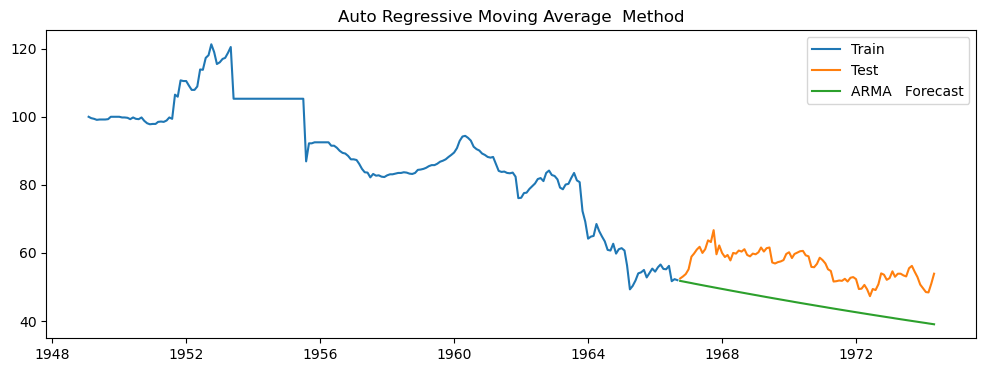

In [38]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label = 'Train')
plt.plot(test['Exchange Rate TWI'], label = 'Test')
plt.plot(y_hat_arma['arma_forecast'][test_data_boxcox_diff.index.min():], label = 'ARMA   Forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Moving Average  Method')
plt.show()

# Calculate RMSE and MAPE

In [39]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_arma['arma_forecast'][train_len-1:])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,11.45,19.55
0,Moving Average (MA) method,11.48,19.60
0,Autoregressive moving average (ARMA) method,11.48,19.60


# Auto regressive integrated moving average (ARIMA)

In [40]:
model = ARIMA(train_data_boxcox, order=(1,1,1))
model_fit = model.fit()
print(model_fit.params)

/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


ar.L1    -0.731289
ma.L1     0.712874
sigma2    0.000743
dtype: float64


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Recover original time series forecast

In [41]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

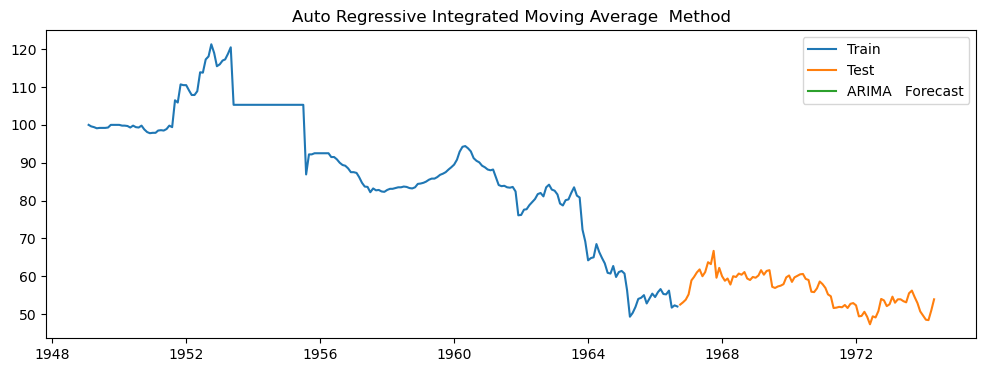

In [42]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label = 'Train')
plt.plot(test['Exchange Rate TWI'], label = 'Test')
plt.plot(y_hat_arima['arima_forecast'][test_data_boxcox_diff.index.min():], label = 'ARIMA   Forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Integrated Moving Average  Method')
plt.show()

## As we can see that there is no plotting done for the ARIMA Forecast. 
-This is due to the reason that the values obtained by the function :
**y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])** are reaching upto infinity or a very high number that cannot be plotted. 
- Due to which we will not bw able to calculate RMSE and MAPE values.

In [43]:
np.all(np.isfinite(y_hat_arima['arima_forecast']))


False

Just as we thought there are infinite values present in the column.

In [44]:
pd.set_option('mode.use_inf_as_na', True) #converting all infinite values to NaN
y_hat_arima['arima_forecast'].fillna(0, inplace=True) #Replacing all NaN values with 0
y_hat_arima['arima_forecast']

1949-02-28    1.000000e+04
1949-03-31    9.960756e+05
1949-04-30    9.900828e+07
1949-05-31    9.812386e+09
1949-06-30    9.733235e+11
                  ...     
1973-12-31    0.000000e+00
1974-01-31    0.000000e+00
1974-02-28    0.000000e+00
1974-03-31    0.000000e+00
1974-04-30    0.000000e+00
Freq: M, Name: predicted_mean, Length: 303, dtype: float64

# Calculate RMSE and MAPE

In [45]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_arima['arima_forecast'][test.index.min():])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,11.45,19.55
0,Moving Average (MA) method,11.48,19.60
0,Autoregressive moving average (ARMA) method,11.48,19.60
0,Autoregressive integrated moving average (ARIM...,56.35,100.00


# Seasonal auto regressive integrated moving average (SARIMA)

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.params)


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60474D+00    |proj g|=  1.96494D+00

At iterate    5    f= -1.83982D+00    |proj g|=  3.91946D+00

At iterate   10    f= -1.90074D+00    |proj g|=  1.66792D-01

At iterate   15    f= -1.93027D+00    |proj g|=  2.69252D+00

At iterate   20    f= -1.95263D+00    |proj g|=  8.02964D-02

At iterate   25    f= -1.96114D+00    |proj g|=  6.62096D-02

At iterate   30    f= -1.96301D+00    |proj g|=  3.54810D-01

At iterate   35    f= -1.96333D+00    |proj g|=  1.21033D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [47]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

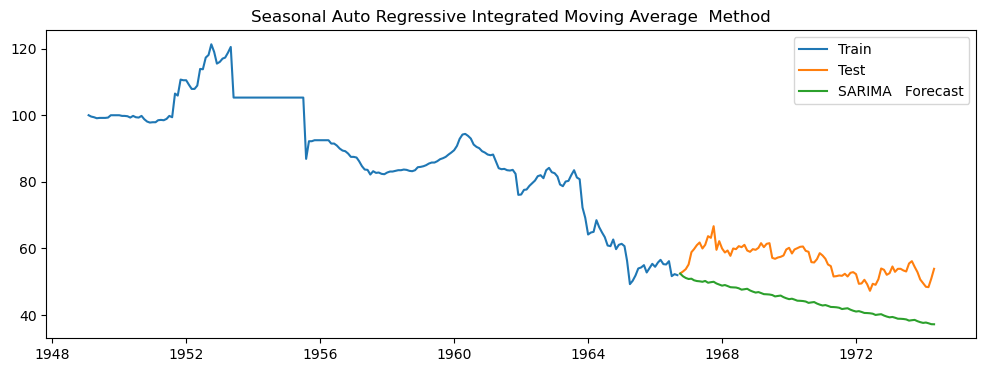

In [48]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label = 'Train')
plt.plot(test['Exchange Rate TWI'], label = 'Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data_boxcox_diff.index.min():], label = 'SARIMA   Forecast')
plt.legend(loc='best')
plt.title('Seasonal Auto Regressive Integrated Moving Average  Method')
plt.show()

## Calculate RMSE and MAPE

In [49]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,11.45,19.55
0,Moving Average (MA) method,11.48,19.60
0,Autoregressive moving average (ARMA) method,11.48,19.60
0,Autoregressive integrated moving average (ARIM...,56.35,100.00
0,Seasonal autoregressive integrated moving aver...,12.47,21.40
